# COMP90086 Final Project

Team Number: 55

Members: Einon McGrory-Perich (992697),     Xing Yang Goh (1001969)

In [56]:
import os 
import math
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from tqdm import tqdm
import sys
import torch
from scipy import ndimage


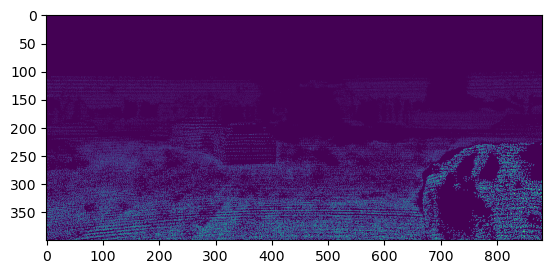

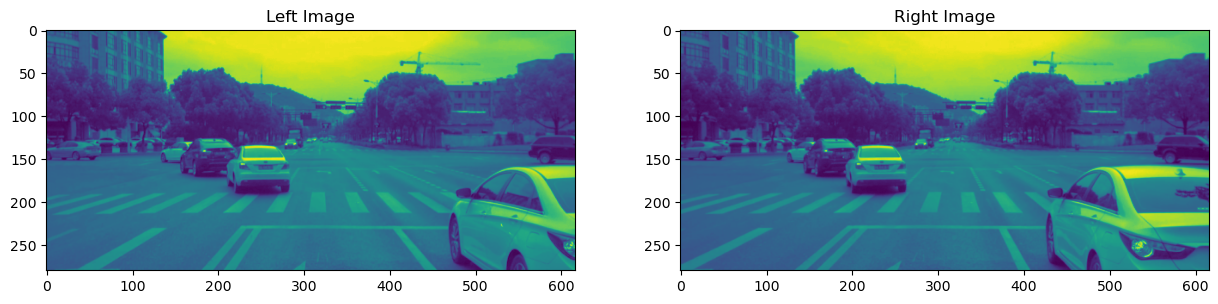

In [422]:
# Import images 
directory = './Dataset/'
allfiles = os.listdir(directory)

filenames = []

for filename in allfiles:
    if 'left' in filename:
        filenames.append(filename[0:filename.index('left')])

# List of files obtained

# Perform on first image for now 

file = filenames[0]

left_image_name = directory + file + 'left.jpg'
right_image_name = directory+ file + 'right.jpg'
disp_image_name = directory+ file + 'disparity.png'


# Read images and convert to RGB 
img_l = cv2.imread(left_image_name)
img_r = cv2.imread(right_image_name)

# Grey images
img_l_grey_full = np.int32(cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY))
img_r_grey_full = np.int32(cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY))
img_l_grey = img_l_grey_full
img_r_grey = img_r_grey_full

img_l = img_l[...,::-1]
img_r = img_r[...,::-1]



img_d = cv2.imread(disp_image_name,-1)/256.0
# img_d = np.int32(cv2.cvtColor(img_d, cv2.COLOR_BGR2GRAY))

# print(img_)
plt.imshow(img_d)

# note: can perform downscaling of the images to speed up computation at the cost of quality degradation
scale_percentage = 70

width = int(img_l_grey_full.shape[1] * scale_percentage / 100)
height = int(img_l_grey_full.shape[0] * scale_percentage / 100)
dim = (width, height)

img_l_grey = np.int32(cv2.resize(img_l_grey_full.astype('float32'), dim, interpolation = cv2.INTER_AREA))
img_r_grey = np.int32(cv2.resize(img_r_grey_full.astype('float32'), dim, interpolation = cv2.INTER_AREA))
img_d = np.float32(cv2.resize(img_d.astype('float32'), dim, interpolation = cv2.INTER_AREA))




# Plot images 
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_l_grey)
plt.title('Left Image')

plt.subplot(1,2,2)
plt.imshow(img_r_grey)
plt.title('Right Image')

plt.show()


In [286]:


import torch
# print
boundary_size = 2

l_image = torch.from_numpy(np.array([img_l_grey])).type(torch.long)
r_image = torch.from_numpy(np.array([img_r_grey])).type(torch.long)
h,w = img_l_grey.shape

# avgpool = torch.nn.AvgPool2d(boundary_size*2, stride=1, padding=boundary_size, divisor_override=1)

num_disparities = 150
ssd = torch.zeros((num_disparities,h,w), dtype=torch.long)
ssd[:,:,:] = 10000000
print(ssd.shape)

for d in range(1,num_disparities):
    diff = (l_image[:,:,d:] - r_image[:,:,:-d])**2
    ssd[d,:,d:] = torch.nn.functional.avg_pool2d(diff, boundary_size*2+1, padding=boundary_size, stride=1, divisor_override=1)

    








# print(ssd[40,20])

torch.Size([150, 160, 352])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 36 31 26 21 21 21
 21 21 21 21 21 21 21 20 20 20 21 21 21 21 21 21 22 22 22 22 21 21 21 21
 21 21 21 16 11  6  1  2  2  2  3  4  4  5  7  7  5  6 10  8 12 13 14 16
 17 17 18 19 21 21 22 23 21 22 23 24 28 29 30 28 32 30 25 20 15 10  5  0]


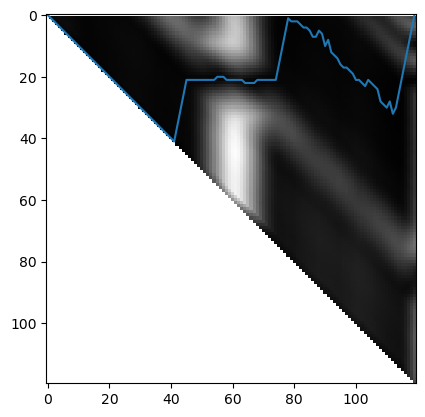

In [417]:
from skimage.graph import shortest_path, route_through_array, MCP
# Code adapted from skimage.shortest_path algorithm
def my_shortest_path(arr, reach=1, axis=-1, output_indexlist=False):
    # First: calculate the valid moves from any given position. Basically,
    # always move +1 along the given axis, and then can move anywhere within
    # a grid defined by the reach.
    if axis < 0:
        axis += arr.ndim
    offset_ind_shape = (2 * reach + 1,) * (arr.ndim - 1)
    offset_indices = np.indices(offset_ind_shape) - reach
    offset_indices = np.insert(offset_indices, axis,
                               np.ones(offset_ind_shape), axis=0)
    offset_size = np.multiply.reduce(offset_ind_shape)
    offsets = np.reshape(offset_indices, (arr.ndim, offset_size), order='F').T

    # Valid starting positions are anywhere on the hyperplane defined by
    # position 0 on the given axis. Ending positions are anywhere on the
    # hyperplane at position -1 along the same.
    non_axis_shape = arr.shape[:axis] + arr.shape[axis + 1:]
    non_axis_indices = np.indices(non_axis_shape)
    non_axis_size = np.multiply.reduce(non_axis_shape)
    start_indices = np.insert(non_axis_indices, axis,
                              np.zeros(non_axis_shape), axis=0)
    starts = np.reshape(start_indices, (arr.ndim, non_axis_size), order='F').T
    end_indices = np.insert(non_axis_indices, axis,
                            np.full(non_axis_shape, -1,
                                    dtype=non_axis_indices.dtype), axis=0)
    ends = np.reshape(end_indices, (arr.ndim, non_axis_size), order='F').T
    
    # Find the minimum-cost path to one of the end-points
    m = MCP(arr, offsets=offsets)

    h,w = arr.shape

    costs, traceback = m.find_costs(starts[0:1], ends[0:1], find_all_ends=True)
    # Figure out which end-point was found
    for end in ends:
        cost = costs[tuple(end)]
        if cost != np.inf:
            break
    traceback = m.traceback(end)

    if not output_indexlist:
        traceback = np.array(traceback)
        traceback = np.concatenate([traceback[:, :axis],
                                    traceback[:, axis + 1:]], axis=1)
        traceback = np.squeeze(traceback)

    return traceback, cost



arr = ssd[0:,140]
arr = np.array([[ np.inf if j > num_disparities else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])
# print(arr)
p, cost = my_shortest_path(arr, reach=5)
print(p)
# p1 = np.arange(2,len(arr))
# # points = np.array([[p1[i], p[i]] for i in range(len(p))])

fig,ax = plt.subplots()
x = np.array(range(len(arr)))

im = ax.imshow(arr, cmap='gray',vmin=0, vmax=100000)

# plt.imshow(ssd[:,140], cmap='gray')
ax.plot(p)

torch.Size([120, 280, 616])


100%|██████████| 274/274 [00:05<00:00, 54.74it/s]


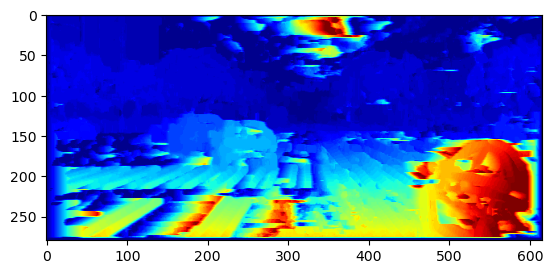

In [423]:
# Optised plotting of the disparity map
h,w = img_l_grey.shape
calc_disp2 = np.zeros((h,w))
boundary_size = 3
neighbourhood_l = 200
neighbourhood_r = 50
step_size = 1
measure = "SSD"
all = []



import torch
# print
boundary_size = 3

l_image = torch.from_numpy(np.array([img_l_grey])).type(torch.long)
r_image = torch.from_numpy(np.array([img_r_grey])).type(torch.long)
h,w = img_l_grey.shape

# avgpool = torch.nn.AvgPool2d(boundary_size*2, stride=1, padding=boundary_size, divisor_override=1)

num_disparities = 120
ssd = torch.zeros((num_disparities,h,w), dtype=torch.long)
ssd[:,:,:] = 10000000 if measure == 'SSD' else 0.01
print(ssd.shape)

for d in range(1,num_disparities):
    if measure == 'SSD':
        diff = (l_image[:,:,d:] - r_image[:,:,:-d])**2
        ssd[d,:,d:] = torch.nn.functional.avg_pool2d(diff, boundary_size*2+1, padding=boundary_size, stride=1, divisor_override=1)
    else: 
        diff = l_image[:,:,d:] * r_image[:,:,:-d]
        norm_corr = 
        #np.sum(patch_l*patch_r, axis=(1,2))/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r, axis=(1,2)))

min_bound = boundary_size
max_bound = w - boundary_size 
    

for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size, step_size)):
    arr = ssd[0:70,row_index]
    # if measure == "SSD":
    #     arr = np.array([[ np.inf if i > num_disparities else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])
    p, cost = my_shortest_path(arr, reach=4)
    p1 = np.arange(0,len(arr))
    # points = np.array([[p[i], p1[i]] for i in range(len(p))])
    disp = p
    calc_disp2[row_index] = disp

    
plt.imshow(calc_disp2, cmap='jet', vmin=0)


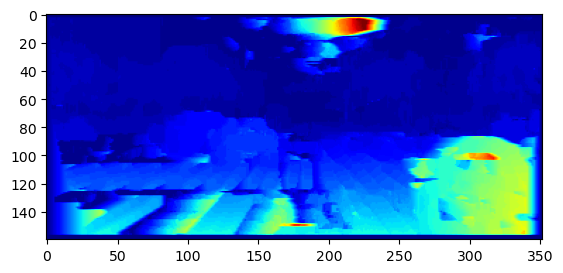

In [421]:
plt.imshow(calc_disp2, cmap='jet', vmin=0)

In [400]:
# Optised plotting of the disparity map
h,w = img_l_grey.shape
calc_disp2 = np.zeros((h,w))
boundary_size = 2
neighbourhood_l = 200
neighbourhood_r = 50
step_size = 1
measure = "SSD"
all = []

for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size, step_size)):
    row = img_l_grey[row_index]
    dsi = []
    for col_index_left in range(boundary_size,len(row)-boundary_size, step_size):

        centre_l = [row_index, col_index_left]

        min_l_x = centre_l[1] - boundary_size
        max_l_x = centre_l[1] + boundary_size+1

        min_l_y = centre_l[0] - boundary_size
        max_l_y = centre_l[0] + boundary_size+1

        patch_l = img_l_grey[min_l_y:max_l_y, min_l_x:max_l_x]

        # Take horizontal window to search, ensuring values don't exceed bounds
        min_bound = boundary_size
        max_bound = len(row)-boundary_size

        # Indices of all column centres to check
        col_centres = np.arange(min_bound,max_bound) 

        # Generate arrays for each column centre in steps of 1 using the boundary size, each having 2*boundary_size elements
        col_linspace = np.int32(np.transpose(np.linspace(col_centres-boundary_size, col_centres+boundary_size, 2*boundary_size+1)))

        # Generate right patch using the constant rows in loop iteration and column arrays, transpose to get correct shape

        patch_r = np.transpose(img_r_grey[min_l_y:max_l_y, col_linspace], (1,0,2)) 


        # Choose distance measure to generate disparity map
        if measure == "NCC":
            norm_corr = np.sum(patch_l*patch_r, axis=(1,2))/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r, axis=(1,2)))
            dsi.append(norm_corr)
            min_col_index = np.argmax(norm_corr) + min_bound - 1
            
        elif measure == "SSD":
            error = np.sum((patch_l-patch_r)**2, axis=(1,2))
            dsi.append(error)
            min_col_indexx = np.argmin(error) + min_bound - 1
    arr = np.transpose(np.array(dsi))
    all.append(dsi)
    if measure == "NCC":
        arr = np.array([[ 0.001 if i > j or i+150 < j else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])
        arr = 1/(arr)
        
    elif measure == "SSD":
        arr = np.array([[ np.inf if i > j else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])
    
    p, cost = my_shortest_path(arr, reach=4)
    p1 = np.arange(0,len(arr))
    points = np.array([[p[i], p1[i]] for i in range(len(p))])
    disp = abs(np.subtract(points[:,1], points[:,0]))
    calc_disp2[row_index][min_bound:max_bound] = disp

    
plt.imshow(calc_disp2, cmap='jet', vmin=0, vmax=255)


 22%|██▏       | 35/156 [00:03<00:10, 11.05it/s]


KeyboardInterrupt: 

In [707]:
print(list((ssd[:,30] == 8689).nonzero(as_tuple=False)))
print(ssd.shape)

# first and third columns are same
# first responds to disparity (difference between each pixel)
# eg, tenth row, means this is the squared differences for every 10 pixel shift

# second vector is the row in which we're looking at.
# eg 30th row would mean every pixel in the 30th horizontal line.
# [10,30] would be the ssd for every pixel shifted 10 pixels in the 30th row 

# The last vector represents the width position
# if this is 50, then im 50 units across the page

# Therefore if i want to find out what my ssd error is:
# Find the error between pixel (30,40) and (30,60)
# ssd = ssd.transpose(1,0)

print(ssd.shape)
# ssd[, 123, 277:281]

[tensor([123, 279])]
torch.Size([352, 161, 352])
torch.Size([352, 161, 352])


In [31]:
# print(np.array(dsi)[-50])
arr = np.array(dsi)
# print(np.where(arr == 13628))
print(arr.shape)


(348, 348)


In [412]:
from skimage.graph import shortest_path, route_through_array, MCP
# Code adapted from skimage.shortest_path algorithm
def my_shortest_path(arr, reach=1, axis=-1, output_indexlist=False):
    # First: calculate the valid moves from any given position. Basically,
    # always move +1 along the given axis, and then can move anywhere within
    # a grid defined by the reach.
    if axis < 0:
        axis += arr.ndim
    offset_ind_shape = (2 * reach + 1,) * (arr.ndim - 1)
    offset_indices = np.indices(offset_ind_shape) - reach
    offset_indices = np.insert(offset_indices, axis,
                               np.ones(offset_ind_shape), axis=0)
    offset_size = np.multiply.reduce(offset_ind_shape)
    offsets = np.reshape(offset_indices, (arr.ndim, offset_size), order='F').T

    # Valid starting positions are anywhere on the hyperplane defined by
    # position 0 on the given axis. Ending positions are anywhere on the
    # hyperplane at position -1 along the same.
    non_axis_shape = arr.shape[:axis] + arr.shape[axis + 1:]
    non_axis_indices = np.indices(non_axis_shape)
    non_axis_size = np.multiply.reduce(non_axis_shape)
    start_indices = np.insert(non_axis_indices, axis,
                              np.zeros(non_axis_shape), axis=0)
    starts = np.reshape(start_indices, (arr.ndim, non_axis_size), order='F').T
    end_indices = np.insert(non_axis_indices, axis,
                            np.full(non_axis_shape, -1,
                                    dtype=non_axis_indices.dtype), axis=0)
    ends = np.reshape(end_indices, (arr.ndim, non_axis_size), order='F').T
    
    # Find the minimum-cost path to one of the end-points
    m = MCP(arr, offsets=offsets)
    print(starts[-2:-1])
    h,w = arr.shape
    costs, traceback = m.find_costs(starts[0:1], ends[-2,-1], find_all_ends=True)
    # Figure out which end-point was found
    for end in ends:
        cost = costs[tuple(end)]
        if cost != np.inf:
            break
    traceback = m.traceback(end)

    if not output_indexlist:
        traceback = np.array(traceback)
        traceback = np.concatenate([traceback[:, :axis],
                                    traceback[:, axis + 1:]], axis=1)
        traceback = np.squeeze(traceback)

    return traceback, cost



In [636]:
boundary_size = 2

for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size)):
    row = img_l_grey[row_index]
    results = []
    for col_index_left in range(boundary_size,len(row)-boundary_size):
        
        centre_l = [row_index, col_index_left]

        min_l_x = centre_l[1] - boundary_size
        max_l_x = centre_l[1] + boundary_size + 1

        min_l_y = centre_l[0] - boundary_size
        max_l_y = centre_l[0] + boundary_size + 1

        patch_l = img_l_grey[min_l_y:max_l_y, min_l_x:max_l_x]

        # Take horizontal window to search, ensuring values don't exceed bounds
        min_bound = boundary_size
        
        max_bound = len(row)-boundary_size
        
        # Indices of all column centres to check
        col_centres = np.arange(min_bound,max_bound) 
        
        
        # Generate arrays for each column centre in steps of 1 using the boundary size, each having 2*boundary_size elements
        col_linspace = np.int32(np.transpose(np.linspace(col_centres-boundary_size, col_centres+boundary_size, 2*boundary_size+1)))


        # Generate right patch using the constant rows in loop iteration and column arrays, transpose to get correct shape
        patch_r = np.transpose(img_r_grey[min_l_y:max_l_y, col_linspace], (1,0,2)) 
        error = np.sum((patch_l-patch_r)**2, axis=(1,2))
        results.append(patch_l)

       

 55%|█████▌    | 86/156 [00:03<00:02, 27.09it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'SSD')

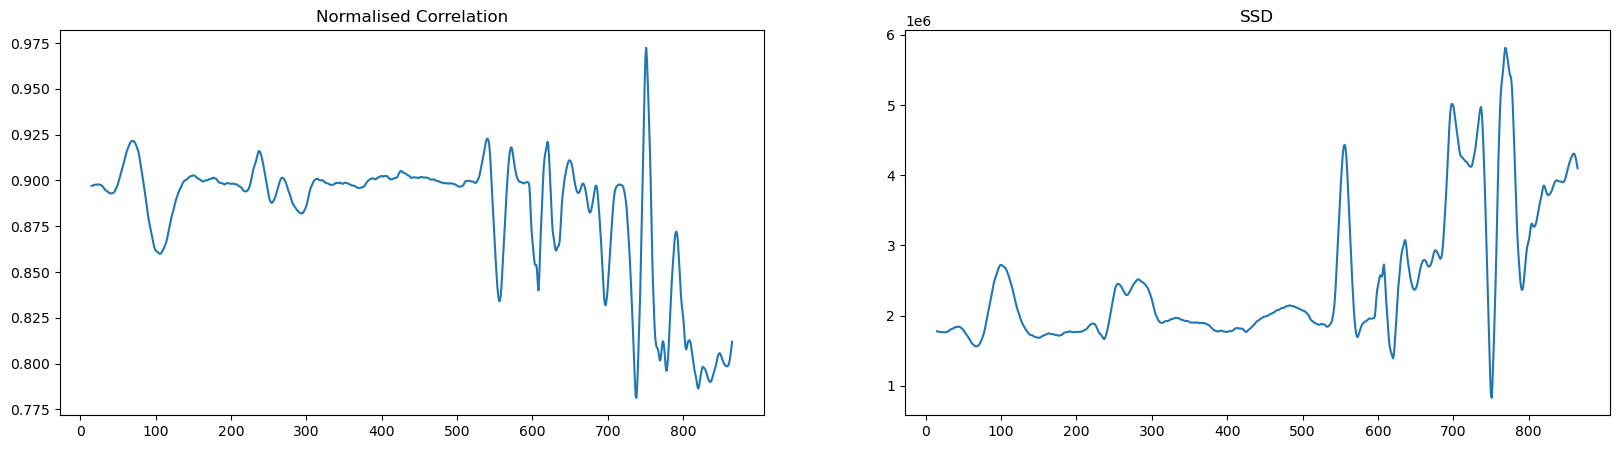

In [220]:
# As driving assume that any two points have the same y value (camera is flat)

# For every y value in both left and right
#     For every x value in left, find the corresponding SSD error (10x10 box) for each x point in right image
#     Select mininum error - treat this as corresponding point

# For every corresponding set of points, find the disparity, x-x'
#     Find depth z by estimating f and baseline distance


# Not certain if this function actually does what I imagine it does

# centre positions given by [row,column]

# sum of squared differenced method to find disparity between images   
def sum_squared_differences(img_l, img_r, centre_l, centre_r, boundary_size):
    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size

    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size
    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size
    
    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    # Error of RGB values
    # error = np.sum((img_l[min_l_y:max_l_y,min_l_x:max_l_x,:] - img_r[min_r_y:max_r_y,min_r_x:max_r_x,:])**2)

    # Error of Grey values
    error = np.sum((patch_l - patch_r)**2)

    return error

def sum_absolute_differences(img_l, img_r, centre_l, centre_r, boundary_size):
    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size

    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size
    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size

    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size

    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    # Error of RGB values
    # error = np.sum((img_l[min_l_y:max_l_y,min_l_x:max_l_x,:] - img_r[min_r_y:max_r_y,min_r_x:max_r_x,:])**2)

    # Error of Grey values
    error = np.sum(abs(patch_l - patch_r))

    return error

    
def norm_correlation(img_l, img_r, centre_l, centre_r, boundary_size):

    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size
    
    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size

    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size

    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = np.int32(img_l[min_l_y:max_l_y, min_l_x:max_l_x].flatten())
    patch_r = np.int32(img_r[min_r_y:max_r_y, min_r_x:max_r_x].flatten())

    norm_corr = np.sum(patch_l*patch_r)/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r))

    return norm_corr

def smoothing_disp(disp_image, centre_l, step_size):
    # Column
    min_l_x = centre_l[1] - step_size
    max_l_x = centre_l[1] + step_size

    # Row
    min_l_y = centre_l[0] - step_size
    max_l_y = centre_l[0] + step_size

    patch = disp_image[min_l_y:max_l_y,min_l_x:max_l_x]

    error = np.sum(abs(patch - disp_image[centre_l[0],centre_l[1]]))

    return error

boundary_size = 15
row = 360
left_image = [row,860]
SSD = []
corr = []
pixel_loc = []
for i in range(boundary_size, len(img_l_grey_full[0])-boundary_size, 1):
    pixel_loc.append(i)
    corr.append(norm_correlation(img_l_grey_full, img_r_grey_full, left_image, [row,i], boundary_size))
    SSD.append(sum_squared_differences(img_l_grey_full, img_r_grey_full, left_image, [row,i], boundary_size))


plt.subplots(1,2, figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pixel_loc, corr)
plt.xticks(np.arange(0, max(pixel_loc), 100))
plt.title('Normalised Correlation')

plt.subplot(1,2,2)
plt.plot(pixel_loc, SSD)
plt.xticks(np.arange(0, max(pixel_loc), 100))
plt.title('SSD')



## INEFFICIENT APPROACH

In [ ]:
# VERY INEFFICIENT APPROACH 
# Plot disparity image
h,w = img_l_grey.shape
calc_disp = np.zeros((h,w))
boundary_size = 8
neighbourhood_l = 150
nighbourhood_r = 50
step_size = 1
measure = "NCC"

for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size, step_size)):
# for row_index in tqdm(range(250,251)):
    row = img_l_grey[row_index]

    # Should be the full bounds, but takes a very long time, consider using tensor operations on rows
    for col_index_left in range(boundary_size,len(row)-boundary_size, step_size):
#     for col_index_left in range(600,602, step_size):
        left_centre = [row_index, col_index_left]
        
        min_error = -math.inf
        min_corr = 0

        # Take horizontal window to search, ensuring values don't exceed bounds
        min_bound = max(col_index_left-neighbourhood_l, boundary_size)
        max_bound = min(col_index_left+nighbourhood_r, len(row)-boundary_size)

        for col_index_right in range(min_bound, max_bound, step_size):
            right_centre = [row_index, col_index_right]

            if measure == "NCC":
                corr = norm_correlation(img_l_grey, img_r_grey, left_centre, right_centre, boundary_size)
                
                if min_corr < corr:
                    min_corr = corr
                    min_col_index = col_index_right
            
            elif measure == "SSD":
                error = sum_squared_differences(img_l_grey, img_r_grey, left_centre, right_centre, boundary_size)

                if error < min_error:
                    min_error = error
                    min_col_index = col_index_right

        calc_disp[row_index][col_index_left] = abs(min_col_index - col_index_left)
        


        
plt.imshow(calc_disp, cmap='gray', vmin=0, vmax=255)

## EFFICIENT APPROACH

In [150]:
# Optised plotting of the disparity map
h,w = img_l_grey.shape
calc_disp1 = np.zeros((h,w))
boundary_size = 3

neighbourhood_l = 200
nighbourhood_r = 50
step_size = 1
measure = "SSD"


for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size, step_size)):
    row = img_l_grey[row_index]

    for col_index_left in range(boundary_size,len(row)-boundary_size, step_size):
        
        centre_l = [row_index, col_index_left]

        min_l_x = centre_l[1] - boundary_size
        max_l_x = centre_l[1] + boundary_size + 1

        min_l_y = centre_l[0] - boundary_size
        max_l_y = centre_l[0] + boundary_size + 1

        patch_l = img_l_grey[min_l_y:max_l_y, min_l_x:max_l_x]

        # Take horizontal window to search, ensuring values don't exceed bounds
        min_bound = max(col_index_left-neighbourhood_l, boundary_size)
        max_bound = min(col_index_left+nighbourhood_r, len(row)-boundary_size)
        
        # Indices of all column centres to check
        col_centres = np.arange(min_bound,max_bound) 
        
        
        # Generate arrays for each column centre in steps of 1 using the boundary size, each having 2*boundary_size elements
        col_linspace = np.int32(np.transpose(np.linspace(col_centres-boundary_size, col_centres+boundary_size, 2*boundary_size+1)))


        # Generate right patch using the constant rows in loop iteration and column arrays, transpose to get correct shape
        patch_r = np.transpose(img_r_grey[min_l_y:max_l_y, col_linspace], (1,0,2)) 

        # Choose distance measure to generate disparity map
        if measure == "NCC":
            norm_corr = np.sum(patch_l*patch_r, axis=(1,2))/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r, axis=(1,2)))
            
            min_col_index = np.argmax(norm_corr) + min_bound - 1
            calc_disp1[row_index][col_index_left] = abs(min_col_index - col_index_left)
        elif measure == "SSD":
            error = np.sum((patch_l-patch_r)**2, axis=(1,2))
            min_col_index = np.argmin(error) + min_bound - 1
            calc_disp1[row_index][col_index_left] = abs(min_col_index - col_index_left)

plt.imshow(calc_disp1, cmap='gray', vmin=0, vmax=255)



  0%|          | 0/394 [00:00<?, ?it/s]


IndexError: index 881 is out of bounds for axis 1 with size 881

In [ ]:
plt.imshow(calc_disp1, cmap='plasma', vmin=0, vmax=255)


In [ ]:
# Implement bilateral filter - edge preserving 
blur = cv2.bilateralFilter(np.uint8(calc_disp1),7,50,50)

plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(blur, cmap='jet', vmin=0, vmax=255)
plt.title('Disparity image')

plt.subplot(1,2,2)
plt.imshow(img_d, cmap='gray', vmin=0, vmax=255)
plt.title('Ground truth')

plt.show()

In [ ]:
col_linspace.shape

In [224]:
h,w = img_l_grey.shape
calc_disp2 = np.zeros((h,w))
boundary_size = 4
neighbourhood_l = 200
neighbourhood_r = 50
step_size = 1
dsi = []

measure = 'NCC'
measure = 'SSD'

row_index=140
row = img_l_grey[row_index]
for col_index_left in range(boundary_size,len(row)-boundary_size, step_size):

    centre_l = [row_index, col_index_left]

    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size+1

    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size+1

    patch_l = img_l_grey[min_l_y:max_l_y, min_l_x:max_l_x]

    # Take horizontal window to search, ensuring values don't exceed bounds
    min_bound = boundary_size
    max_bound = len(row)-boundary_size

    # Indices of all column centres to check
    col_centres = np.arange(min_bound,max_bound) 
    
    # Generate arrays for each column centre in steps of 1 using the boundary size, each having 2*boundary_size elements
    col_linspace = np.int32(np.transpose(np.linspace(col_centres-boundary_size, col_centres+boundary_size, 2*boundary_size+1)))
    # Generate right patch using the constant rows in loop iteration and column arrays, transpose to get correct shape
    
    patch_r = np.transpose(img_r_grey[min_l_y:max_l_y, col_linspace], (1,0,2)) 
    

    # Choose distance measure to generate disparity map
    if measure == "NCC":
        norm_corr = np.sum(patch_l*patch_r, axis=(1,2))/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r, axis=(1,2)))
        dsi.append(norm_corr)
        min_col_index = np.argmax(norm_corr) + min_bound - 1
        calc_disp2[row_index][col_index_left] = abs(min_col_index - col_index_left)
    elif measure == "SSD":
        error = np.sum((patch_l-patch_r)**2, axis=(1,2))
        dsi.append(error)
        min_col_index = np.argmin(error) + min_bound - 1
        calc_disp2[row_index][col_index_left] = abs(min_col_index - col_index_left)

In [397]:
from skimage.graph import shortest_path, route_through_array, MCP
# Code adapted from skimage.shortest_path algorithm
def my_shortest_path(arr, reach=1, axis=-1, output_indexlist=False):
    # First: calculate the valid moves from any given position. Basically,
    # always move +1 along the given axis, and then can move anywhere within
    # a grid defined by the reach.
    if axis < 0:
        axis += arr.ndim
    offset_ind_shape = (2 * reach + 1,) * (arr.ndim - 1)
    offset_indices = np.indices(offset_ind_shape) - reach
    offset_indices = np.insert(offset_indices, axis,
                               np.ones(offset_ind_shape), axis=0)
    offset_size = np.multiply.reduce(offset_ind_shape)
    offsets = np.reshape(offset_indices, (arr.ndim, offset_size), order='F').T

    # Valid starting positions are anywhere on the hyperplane defined by
    # position 0 on the given axis. Ending positions are anywhere on the
    # hyperplane at position -1 along the same.
    non_axis_shape = arr.shape[:axis] + arr.shape[axis + 1:]
    non_axis_indices = np.indices(non_axis_shape)
    non_axis_size = np.multiply.reduce(non_axis_shape)
    start_indices = np.insert(non_axis_indices, axis,
                              np.zeros(non_axis_shape), axis=0)
    starts = np.reshape(start_indices, (arr.ndim, non_axis_size), order='F').T[0:1]
    end_indices = np.insert(non_axis_indices, axis,
                            np.full(non_axis_shape, -1,
                                    dtype=non_axis_indices.dtype), axis=0)
    ends = np.reshape(end_indices, (arr.ndim, non_axis_size), order='F').T[-2:-1]
    
    # Find the minimum-cost path to one of the end-points
    m = MCP(arr, offsets=offsets)
    costs, traceback = m.find_costs(starts, ends, find_all_ends=True)
    # Figure out which end-point was found
    for end in ends:
        cost = costs[tuple(end)]
        if cost != np.inf:
            break
    traceback = m.traceback(end)

    if not output_indexlist:
        traceback = np.array(traceback)
        traceback = np.concatenate([traceback[:, :axis],
                                    traceback[:, axis + 1:]], axis=1)
        traceback = np.squeeze(traceback)

    return traceback, cost

# arr = np.transpose(np.array(dsi))

# arr = np.array([[ np.inf if  i > j else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])
# arr = np.array([[ np.inf if  i+200 < j else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])

# # arr = (1/arr)
# # epsilon = 0.01
# # arr = np.array([[ 1 if arr[i,j]-1 < epsilon and i < j else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])


# p, cost = my_shortest_path(arr, reach=3)

# p1 = np.arange(0,len(arr))
# points = np.array([[p[i], p1[i]] for i in range(len(p))])

# fig,ax = plt.subplots()
# x = np.array(range(len(arr)))

# im = ax.imshow(arr, cmap='gray',vmin=0)

# ax.plot(x)
# ax.plot(points)




100%|██████████| 154/154 [00:14<00:00, 10.49it/s]


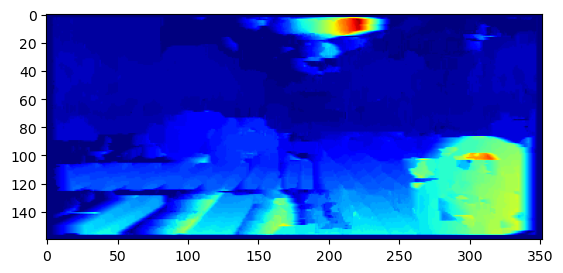

In [407]:
# Optised plotting of the disparity map
h,w = img_l_grey.shape
calc_disp2 = np.zeros((h,w))
boundary_size = 3
neighbourhood_l = 200
neighbourhood_r = 50
step_size = 1
measure = "SSD"


for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size, step_size)):
    row = img_l_grey[row_index]
    dsi = []
    for col_index_left in range(boundary_size,len(row)-boundary_size, step_size):

        centre_l = [row_index, col_index_left]

        min_l_x = centre_l[1] - boundary_size
        max_l_x = centre_l[1] + boundary_size+1

        min_l_y = centre_l[0] - boundary_size
        max_l_y = centre_l[0] + boundary_size+1

        patch_l = img_l_grey[min_l_y:max_l_y, min_l_x:max_l_x]

        # Take horizontal window to search, ensuring values don't exceed bounds
        min_bound = boundary_size
        max_bound = len(row)-boundary_size

        # Indices of all column centres to check
        col_centres = np.arange(min_bound,max_bound) 

        # Generate arrays for each column centre in steps of 1 using the boundary size, each having 2*boundary_size elements
        col_linspace = np.int32(np.transpose(np.linspace(col_centres-boundary_size, col_centres+boundary_size, 2*boundary_size+1)))

        # Generate right patch using the constant rows in loop iteration and column arrays, transpose to get correct shape

        patch_r = np.transpose(img_r_grey[min_l_y:max_l_y, col_linspace], (1,0,2)) 


        # Choose distance measure to generate disparity map
        if measure == "NCC":
            norm_corr = np.sum(patch_l*patch_r, axis=(1,2))/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r, axis=(1,2)))
            dsi.append(norm_corr)
            min_col_index = np.argmax(norm_corr) + min_bound - 1
            
        elif measure == "SSD":
            error = np.sum((patch_l-patch_r)**2, axis=(1,2))
            dsi.append(error)
            min_col_indexx = np.argmin(error) + min_bound - 1
    

    arr = np.transpose(np.array(dsi))
    
    if measure == "NCC":
        arr = np.array([[ 0.001 if i > j or i+150 < j else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])
        arr = 1/(arr)
        
    elif measure == "SSD":
        arr = np.array([[ np.inf if i > j else arr[i,j] for j in range(len(arr))] for i in range(len(arr))])
    
    p, cost = my_shortest_path(arr, reach=4)
    p1 = np.arange(0,len(arr))
    points = np.array([[p[i], p1[i]] for i in range(len(p))])

    disp = abs(np.subtract(points[:,1], points[:,0]))
    calc_disp2[row_index][min_bound:max_bound] = disp
    
plt.imshow(calc_disp2, cmap='jet', vmin=0)


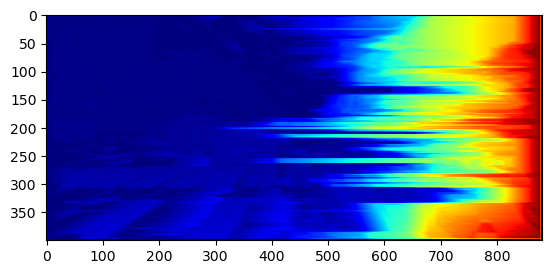

In [389]:
plt.imshow(calc_disp2, cmap='jet', vmin=0)

In [ ]:
# Use a median filter to remove horizontal streaks (Incresing filter size reduces RMSE but after ~30 the pixel fraction accuracy begins to drop)
calc_disp3 = np.zeros((h,w))
median_filter_size = (25,25)



calc_disp3 = ndimage.median_filter(calc_disp2, median_filter_size)


plt.imshow(calc_disp3, cmap='jet', vmin=0)

h,w = img_d.shape

MSE = []

for i in range(h):
    for j in range(w):
        if img_d[i,j] != 0:
            MSE.append(np.square(calc_disp3[i,j]-img_d[i,j]))

MSE = np.array(MSE)
RMSE = math.sqrt(MSE.mean())
print("Root Mean Square Error:")
print(RMSE)

pixError = []

for i in range(h):
    for j in range(w):
        if img_d[i,j] != 0:
            pixError.append(abs(calc_disp3[i,j]-img_d[i,j]))

pixError = np.array(pixError)
for i in [0.25,0.5,1,2,4][::-1]:
    print(f'Fraction of {len(pixError[pixError < i])/len(img_d[img_d>0]):.2f} with pixel error less than {i} pixels')

In [ ]:
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(calc_disp1, cmap='jet',vmin=0)
plt.title('Disparity image without smoothing')

plt.subplot(1,2,2)
plt.imshow(blur, cmap='jet',vmin=0)
plt.title('Disparity image using bilateral filter')

# print(list(img_d))
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(calc_disp2, cmap='jet',vmin=0)
plt.title('Disparity image using shortest path')

plt.subplot(1,2,2)
plt.imshow(img_d, cmap='jet',vmin=0)
plt.title('Ground truth')

plt.show()


In [ ]:
h,w = img_d.shape

MSE = []

for i in range(h):
    for j in range(w):
        if img_d[i,j] != 0:
            MSE.append(abs(calc_disp3[i,j]-img_d[i,j]))

MSE = np.array(MSE)
for i in [0.25,0.5,1,2,4][::-1]:
    print(f'Fraction of {len(MSE[MSE < i])/len(img_d[img_d>0]):.2f} with pixel error less than {i} pixels')
            

